In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys
import time

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import jax 
import jax.numpy as jnp

In [4]:
import numpyro as npr
from numpyro import sample, plate, deterministic
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value

/mnt/data/tng/phd/DCM/DCM_ERP_new/.pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
npr.set_platform("cpu")

In [6]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.23
Numpyro version: 0.14.0
Arviz version: 0.18.0


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [9]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler
from Helper.ERPhelper import *

In [10]:
def aic(log_lik, nprms):
    return 2 * nprms - 2 * np.max(log_lik)

def bic(log_lik, nparams, ndata):
    k = nparams
    n = ndata
    return -2 * np.max(log_lik) + k * np.log(n)

## Simulator

In [11]:
rng_key = jax.random.PRNGKey(0)

In [12]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

ns = 9
x_init=np.zeros((ns))

In [13]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

Run the model

In [14]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 122 ms, sys: 1.55 ms, total: 124 ms
Wall time: 119 ms


We use Euler integration (see the ForwardModel for Heun and Rk4 integratores), But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [15]:
@jax.jit
def ERP_JAXOdeintSimulator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [16]:
start_time = time.time()
xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)
print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.09994006156921387


In [17]:
start_time = time.time()
xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)
print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.0006759166717529297


## Synthetic Observation

In [18]:
#observation noise
sigma_true = 0.1 

In [19]:
xpy_jax = ERP_JAXOdeintSimulator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [20]:
#downsampling
ds=10

In [21]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [22]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [23]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

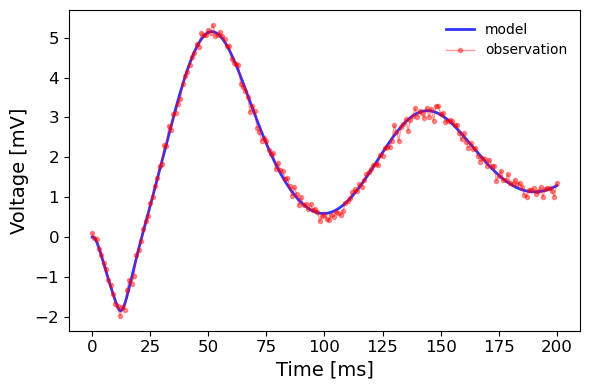

In [24]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);

## Prior

In [25]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [26]:
prior_specs = dict(shape=shape, rate=rate)

In [27]:
def model(data, prior_specs, model_id=0):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    obs = data['xpy_obs']

    # Prior   
    if model_id == 1 :
        g_1 = 0
    else :
        g_1 = sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0])) 
    if model_id == 2 :
        g_2 = 0        
    else :
        g_2 = sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    if model_id == 3 :
        g_3 = 0
    else :
        g_3 = sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    if model_id == 4:
        g_4 = 0
    else :
        g_4 = sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
        
    delta = sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    #Parameters    
    params_samples = [g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimulator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = deterministic('xpy_model', xpy_hat)
        sample('xpy_obs', dist.Normal(xpy_model, obs_err), obs=obs)
        xpy_ppc = sample('xpy_ppc', dist.Normal(xpy_model, obs_err))

## NUTS sampling

In [28]:
n_models = 5
model_labels = ['Full model', r'$g_1 = 0$', r'$g_2 = 0$', r'$g_3 = 0$', r'$g_4 = 0$']
model_nparams = [n_params, n_params-1, n_params-1, n_params-1, n_params-1]

In [29]:
n_warmup, n_samples, n_chains = 200, 200, 4

In [30]:
az_mcmc_fits = []

for imodel in range(n_models) :
    
    #prior and initialization
    n_ = 100
    prior_predictive = Predictive(model, num_samples=n_)
    prior_predictions = prior_predictive(rng_key, data, prior_specs,  model_id=imodel)
    tails_5th_percentile = tails_percentile(my_var_names, prior_predictions, 0.05)
    init_to_low_prob = init_to_value(values=tails_5th_percentile)
    
    # NUTS set up
    kernel = NUTS(model, max_tree_depth=10,  dense_mass=False, adapt_step_size=True, init_strategy=init_to_low_prob)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_samples, num_chains=n_chains, chain_method='parallel')
    
    #RUN NUTS
    start_time = time.time()
    mcmc.run(rng_key, data, prior_specs, model_id=imodel, 
             extra_fields=('potential_energy', 'num_steps', 'diverging'))
    print("Model " + str(imodel) + " using NUTS' Numpyro took (sec):" , (time.time() - start_time))
    
    az_mcmc_fits.append(az.from_numpyro(mcmc))

sample: 100%|██████████| 400/400 [00:51<00:00,  7.84it/s, 511 steps of size 6.88e-03. acc. prob=0.94] 


Model 0 using NUTS' Numpyro took (sec): 236.34547185897827


sample: 100%|██████████| 400/400 [00:49<00:00,  8.03it/s, 511 steps of size 7.83e-03. acc. prob=0.94] 


Model 1 using NUTS' Numpyro took (sec): 204.49950170516968


sample: 100%|██████████| 400/400 [00:04<00:00, 81.43it/s, 15 steps of size 3.76e-01. acc. prob=0.87] 


Model 2 using NUTS' Numpyro took (sec): 22.12941074371338


sample: 100%|██████████| 400/400 [00:40<00:00,  9.96it/s, 511 steps of size 1.31e-02. acc. prob=0.94] 


Model 3 using NUTS' Numpyro took (sec): 144.2980284690857


sample: 100%|██████████| 400/400 [00:31<00:00, 12.72it/s, 255 steps of size 1.55e-02. acc. prob=0.94] 


Model 4 using NUTS' Numpyro took (sec): 127.305011510849


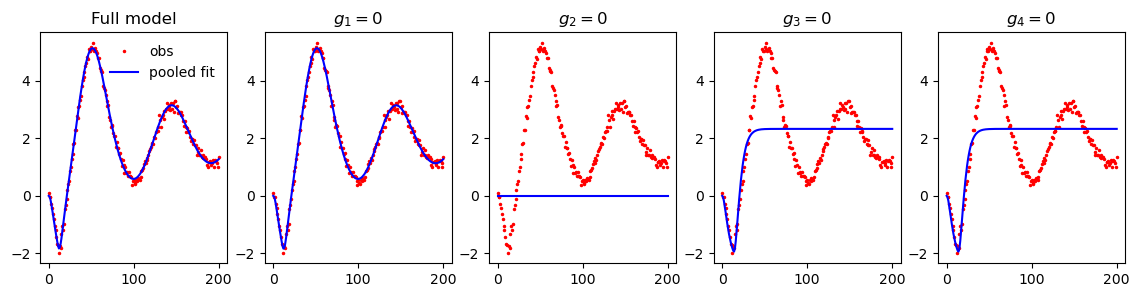

In [31]:
fig, ax = plt.subplots(ncols=n_models, figsize=(14, 3))

for i in range(n_models) :
    ax[i].plot(xpy_obs, 'r.', markersize=3, label='obs')
    ax[i].set_title(model_labels[i])
    xpy_fit = az_mcmc_fits[i].posterior['xpy_model']
    ax[i].plot(xpy_fit.mean(axis=(0, 1)), color='b', label='pooled fit')
ax[0].legend(frameon=False)
fig.show()

## Model comparison using information criteria

In [32]:
models_aic = [aic(-az_mcmc_fits[i].sample_stats['lp'].values, model_nparams[i]) for i in range(n_models)]

In [33]:
models_bic = [bic(-az_mcmc_fits[i].sample_stats['lp'].values, model_nparams[i], nt_obs) for i in range(n_models)]

In [34]:
models_waic = [az.waic(az_mcmc_fits[i], scale='deviance').elpd_waic for i in range(n_models)]

In [35]:
models_loo = [az.loo(az_mcmc_fits[i], scale='deviance').elpd_loo for i in range(n_models)]

We now make all the criteria on the negative log scale. They were on the "deviance" scale, i.e. -2 log . The best model is the one that minimizes the deviance or negative log scale criteria.


In [36]:
models_ic = pd.DataFrame({'loo': 0.5*np.array(models_loo), 
                          'waic': 0.5*np.array(models_waic), 
                          'aic': 0.5*np.array(models_aic), 
                          'bic': 0.5*np.array(models_bic),
                          'model': model_labels})

In [37]:
models_ic

,loo,waic,aic,bic,model
0,-158.737959,-158.772136,-358.903259,-342.386735,Full model
1,-158.870938,-158.915853,-365.216980,-350.352108,$g_1 = 0$
2,62638.891107,62638.893012,62438.406250,62453.271122,$g_2 = 0$
3,14499.534337,14488.917382,14213.208008,14228.072880,$g_3 = 0$
4,14496.993400,14503.342475,14215.019531,14229.884403,$g_4 = 0$


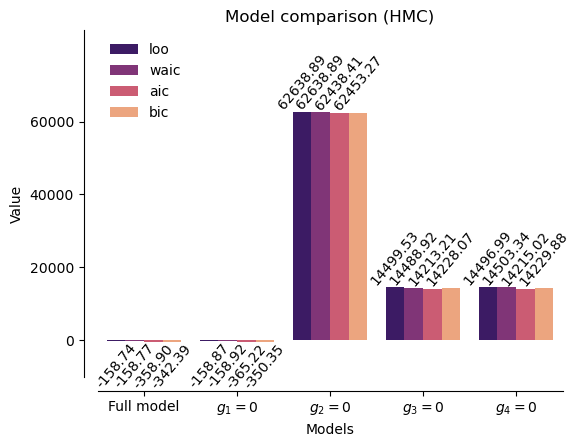

In [38]:
fig, ax = plt.subplots(figsize=(6, 4.5))
sns.barplot(models_ic.melt('model', var_name='criterion'), 
            x='model', 
            y='value', 
            hue='criterion', 
            palette='magma', 
            ax=ax)
for i in range(4) :
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10, rotation=50)
    
ax.set_ylim([-10000, 85000])
ax.set_yticks(range(0, 65000, 20000))   
ax.set_xticks(range(5))
ax.set_xlabel('Models')
ax.set_ylabel('Value')
ax.legend(frameon=False, loc='upper left')
ax.set_title('Model comparison (HMC)') 
sns.despine(offset=10) ;

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jul 15 2024

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 8.11.0

arviz       : 0.15.1
clb_nb_utils: 0.1.0.dev0
jax         : 0.4.13
numpyro     : 0.12.1
numpy       : 1.23.5
seaborn     : 0.12.2
matplotlib  : 3.7.3
pandas      : 2.0.3

Watermark: 2.4.3

